# Neural Style Transfer


## Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

Helper functions for loading, displaying and preprocessing the content and style images:

In [2]:
# Reverse from tensor back to image: 
def tensor_to_image(tensor):
    '''converts a tensor to an image'''
    tensor_shape = tf.shape(tensor)
    number_elem_shape = tf.shape(tensor_shape)
    if number_elem_shape > 3:
        assert tensor_shape[0] == 1
        tensor = tensor[0]
    return tf.keras.preprocessing.image.array_to_img(tensor) 

# Load single image and scale it to 512 pixels: 
def load_img(path_to_img):
    '''loads an image as a tensor and scales it to 512 pixels'''
    max_dim = 512
    image = tf.io.read_file(path_to_img)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    shape = tf.shape(image)[:-1]
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]
    image = tf.image.convert_image_dtype(image, tf.uint8)

    return image

# Load the contant and style images with load_img
def load_images(content_path, style_path):
    '''loads the content and path images as tensors'''
    content_image = load_img("{}".format(content_path))
    style_image = load_img("{}".format(style_path))

    return content_image, style_image

# Display content and style images with thier file name as the title
def imshow(image, title=None):
    '''displays an image with a corresponding title'''
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)
    
# A wrapper function for imshow, defining the size of the image..     
def show_images_with_objects(images, titles=[]):
    '''displays a row of images with corresponding titles'''
    if len(images) != len(titles):
        return

    plt.figure(figsize=(20, 12))
    for idx, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), idx + 1)
        plt.xticks([])
        plt.yticks([])
        imshow(image, title)

# Clip image value to maintain values between 0-255:
def clip_image_values(image, min_value=0.0, max_value=255.0):
    '''clips the image pixel values by the given min and max'''
    return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)

# Preprocess an image for inception model:
def preprocess_image(image):
    '''preprocesses a given image to use with Inception model'''
    image = tf.cast(image, dtype=tf.float32)
    image = (image / 127.5) - 1.0

    return image

## Download Images

In [3]:
# Define contant and style images: 
content_path = 'Kelly.JPG'
# Use 'tf.keras.utils.get_file' for downloading a file from the web:

style_path = tf.keras.utils.get_file('lupo3.jpg','https://image.invaluable.com/housePhotos/tiroche/48/290448/H2594-L17599504.jpg')

245760/240335 [==============================] - 0s 1us/step


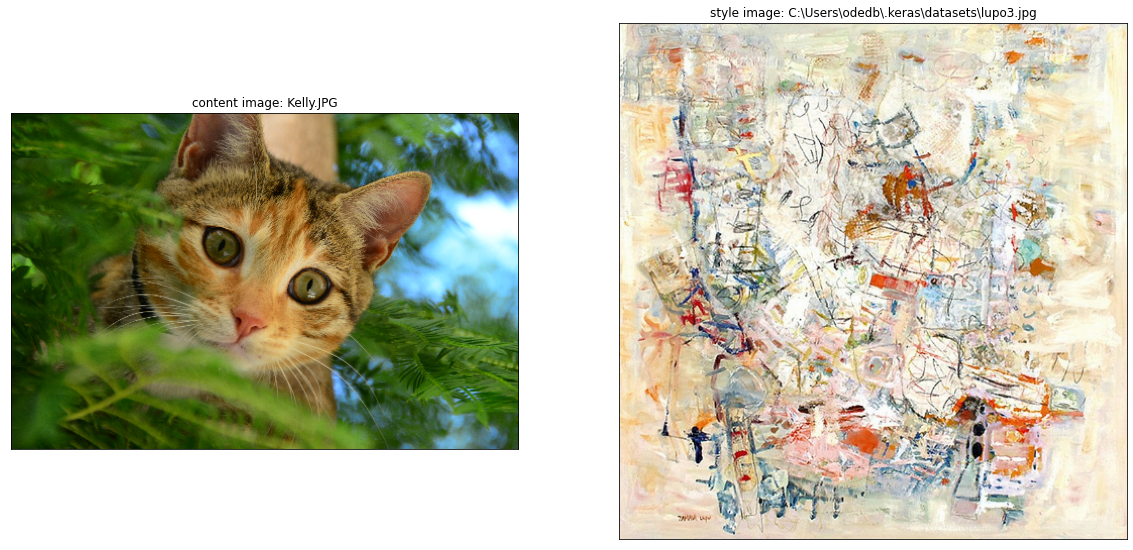

In [4]:
# Display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image], 
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

## Build the feature extractor
I will use the inception model with pretrained weights as my feature extructor, but for know I will only display it's layers: 


In [5]:
# clear session to make layer naming consistent when re-running this cell
K.clear_session()

# download the inception model and inspect the layers
tmp_inception = tf.keras.applications.InceptionV3()
tmp_inception.summary()

# delete temporary model
del tmp_inception

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Now I will choose the layers from the network to represent the style and content of the image: it is important to choose early stage layers for the style and an extended layer for the contant, since the style layers holds low level information mostly about the texture of the image and an extended layer for the contant which holds an embeded information about the higher features of the image. 
for the style layers we can pick a number of layers, where for the contant layer its better to pick only one.   


In [6]:
# choose the content layer and put in a list
content_layers = ['conv2d_87']

# choose the five style layers of interest
style_layers = ['conv2d','conv2d_1','conv2d_2','conv2d_3','conv2d_4','conv2d_8','conv2d_6']

# combine the content and style layers into one list
content_and_style_layers = style_layers + content_layers 

# count the number of content layers and style layers.
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

Now I will setup the inception model with the selected layers as outputs.


In [7]:
def inception_model(layer_names):
    """ Creates a inception model that returns a list of intermediate output values.
    args:
    layer_names: a list of strings, representing the names of the desired content and style layers

    returns:
    A model that takes the regular inception v3 input and outputs just the content and style layers.

    """
    # Load InceptionV3 with the imagenet weights and **without** the 3 fully-connected layers at the top of the network
    inception = tf.keras.applications.inception_v3.InceptionV3(include_top = False, weights= 'imagenet')

    # Freeze the weights of the model's layers (make them not trainable)
    inception.trainable = False

    # Create a list of layer objects that are specified by layer_names
    output_layers = [inception.get_layer(name).output for name in layer_names]

    # Create the model that outputs the content and style layers
    model = tf.keras.models.Model(inputs = inception.input, outputs = output_layers)

    # return the model
    return model 

Create an instance of the content and style model using the function that you just defined

In [8]:
K.clear_session()

inception = inception_model(content_and_style_layers)
inception

## Define the style loss

The style loss is the average of the squared differences between the features and targets. The features and targets are the gram matrix of the style image and the generated image respectively. 

In [9]:
def get_style_loss(features, targets):
    """Expects two images of dimension h, w, c

    Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)

    Returns:
    style loss (scalar)
    """
    ### START CODE HERE ###

    # Calculate the style loss
    style_loss = tf.reduce_mean(tf.square(features - targets))

    ### END CODE HERE ###
    return style_loss

## Define content loss

Calculate the sum of the squared error between the features and targets, then multiply by a scaling factor (0.5).

In [10]:
def get_content_loss(features, targets):
    """Expects two images of dimension h, w, c

    Args:
    features: tensor with shape: (height, width, channels)
    targets: tensor with shape: (height, width, channels)

    Returns:
    content loss (scalar)
    """
    # get the sum of the squared error multiplied by a scaling factor
    content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))

    return content_loss

## Calculate the gram matrix for the style features:


In [11]:
def gram_matrix(input_tensor):
    """ Calculates the gram matrix and divides by the number of locations
    Args:
    input_tensor: tensor of shape (batch, height, width, channels)

    Returns:
    scaled_gram: gram matrix divided by the number of locations
    """

    # calculate the gram matrix of the input tensor
    gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

    # get the height and width of the input tensor
    input_shape = tf.shape(input_tensor) 
    height = input_shape[1] 
    width = input_shape[2] 

    # get the number of locations (height times width), and cast it as a tf.float32
    num_locations = tf.cast(height * width, tf.float32)

    # scale the gram matrix by dividing by the number of locations
    scaled_gram = gram / num_locations

    return scaled_gram

## Get the style image features


For each style layer, calculate the gram matrix and store the results in a list.

In [12]:
def get_style_image_features(image):  
    """ Get the style image features

    Args:
    image: an input image

    Returns:
    gram_style_features: the style features as gram matrices
    """
    # preprocess the image using the given preprocessing function
    preprocessed_style_image = preprocess_image(image) 

    # get the outputs from the inception model that you created using inception_model()
    outputs = inception(preprocessed_style_image) 

    # Get just the style feature layers (exclude the content layer)
    style_outputs = outputs[:NUM_STYLE_LAYERS]

    # for each style layer, calculate the gram matrix for that layer and store these results in a list
    gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]

    return gram_style_features

## Get content image features

the contant image feature is actually the embeded layer that was chosen earlier, remember that it is an extended layer that holds high level features of the image. 

In [13]:
def get_content_image_features(image):
    """ Get the content image features

    Args:
    image: an input image

    Returns:
    content_outputs: the content features of the image
    """
    # preprocess the image
    preprocessed_content_image = preprocess_image(image)

    # get the outputs from the inception model
    outputs = inception(preprocessed_content_image)

    # get the content layer of the outputs
    content_outputs = outputs[NUM_STYLE_LAYERS:]

    return content_outputs

## Define the total loss

The total loss is given by $L_{total} = \beta L_{style} + \alpha L_{content}$, where $\beta$ and $\alpha$ are the style and content weights, respectively.


In [14]:
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, beta, alpha):
    """ Combine the style and content loss

    Args:
    style_targets: style features of the style image
    style_outputs: style features of the generated image
    content_targets: content features of the content image
    content_outputs: content features of the generated image
    beta: weight given to the style loss
    alpha: weight given to the content loss

    Returns:
    total_loss: the combined style and content loss

    """

    # Sum of the style losses
    style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])

    # Sum up the content losses
    content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

    # scale the style loss by multiplying by the style weight and dividing by the number of style layers
    style_loss =  style_loss * beta / NUM_STYLE_LAYERS

    # scale the content loss by multiplying by the content weight and dividing by the number of content layers
    content_loss = content_loss * alpha / NUM_CONTENT_LAYERS 

    # sum up the style and content losses
    total_loss = style_loss + content_loss 

    # return the total loss
    return total_loss

## Calculate gradients

Get the gradients of the loss with respect to the input image.

In [15]:
def calculate_gradients(image, style_targets, content_targets, 
                        beta, alpha):
    """ Calculate the gradients of the loss with respect to the generated image
    Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    beta: weight given to the style loss
    alpha: weight given to the content loss

    Returns:
    gradients: gradients of the loss with respect to the input image
    """

    with tf.GradientTape() as tape:

        # get the style image features
        style_features = get_style_image_features(image) 

        # get the content image features
        content_features = get_content_image_features(image) 

        # get the style and content loss
        loss = get_style_content_loss(style_targets, style_features, content_targets, 
                                      content_features, beta, alpha) 

    # calculate gradients of loss with respect to the image
    gradients = tape.gradient(loss, image) 

    return gradients, loss

## Update the image with the style

A function that applies the gradients to the generated/stylized image.

In [16]:
def update_image_with_style(image, style_targets, content_targets, beta, 
                            alpha, optimizer):
    """
    Args:
    image: generated image
    style_targets: style features of the style image
    content_targets: content features of the content image
    beta: weight given to the style loss
    alpha: weight given to the content loss
    optimizer: optimizer for updating the input image
    """
    # Calculate gradients using the function that you just defined.
    gradients, loss = calculate_gradients(image, style_targets, content_targets, 
                                   beta, alpha) 

    # apply the gradients to the given image
    optimizer.apply_gradients([(gradients, image)])

    # Clip the image using the given clip_image_values() function
    image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

    return loss

## Generate the stylized image

Please complete the function below to implement neural style transfer between your content and style images.

In [17]:
def fit_style_transfer(style_image, content_image, beta=1e-2, alpha=1e-4, 
                       optimizer='adam', epochs=1, steps_per_epoch=1):
    """ Performs neural style transfer.
    Args:
    style_image: image to get style features from
    content_image: image to stylize 
    style_targets: style features of the style image
    content_targets: content features of the content image
    beta: weight given to the style loss
    alpha: weight given to the content loss
    optimizer: optimizer for updating the input image
    epochs: number of epochs
    steps_per_epoch = steps per epoch

    Returns:
    generated_image: generated image at final epoch
    images: collection of generated images per epoch  
    """

    images = []
    step = 0

    #First we will get the style and content features from the style image and content image respectively: 
    # get the style image features 
    style_targets = get_style_image_features(style_image)

    # get the content image features
    content_targets = get_content_image_features(content_image)

    # Handling the generated image:
    # initialize the generated image for updates
    generated_image = tf.cast(content_image, dtype=tf.float32)
    generated_image = tf.Variable(generated_image) 

    # collect the image updates starting from the content image
    images.append(content_image)

    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1

            # Update the image with the style using the function that you defined
            loss = update_image_with_style(generated_image, style_targets, content_targets, 
                                  beta, alpha, optimizer)


            print(".", end='')
            if (m + 1) % 10 == 0:
                images.append(generated_image)
    
        # display the current stylized image
        clear_output(wait=True)
        display_image = tensor_to_image(generated_image)
        display_fn(display_image)

        # append to the image collection for visualization later
        images.append(generated_image)
        print("Train step: {}".format(step))
        print("loss: " + str(loss))

    # convert to uint8 (expected dtype for images with pixels in the range [0,255])
    generated_image = tf.cast(generated_image, dtype=tf.uint8)

    return generated_image, images

Run the main loop to generate the stylized image:

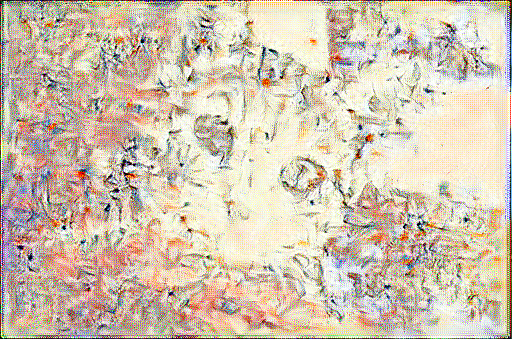

Train step: 2000
loss: tf.Tensor(0.0004978666, shape=(), dtype=float32)


In [18]:
# define style and content weight
style_weight =  1
content_weight = 1e-16 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    beta=style_weight, alpha=content_weight,
                                                    optimizer=adam, epochs=20, steps_per_epoch=100)